# Qualitative Evaluation of Vase Data

In previous work, we have shown how the HRNet keypoint detector and Faster R-CNN object detector do not generalize to images with the style of Greek vase paintings. To overcome this issue, we used transfer learning and retrained both methods using a Styled version of the COCO dataset. We have also seen how this tuning procedure significantly improves the (qualitative and quantitative) performance of the models on the Styled COCO validation set.

In this notebook, we perform a similar qualitative evaluation. However, we now investigate how well our models perform directly on Greek vase painting data. In particular, we investigate how different models perform human pose estimation when applied on Greek vase painting data. 

<div class=alert style="background-color:#F5F5F5; border-color:#C8C8C8">
   So far I have no models tuned on Greek vase painting data. The models here used have been trained/tuned using uniquely data from the MS-COCO and Styled-COCO datasets.
</div> 

In [1]:
import os
import sys
from tqdm import tqdm

import numpy as np
import cv2
import torch
from torch.nn import DataParallel
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import matplotlib.pyplot as plt

sys.path.append("..")

import models
import data
from data.data_loaders import get_vase_subset 
import data.data_processing as data_processing
from lib.transforms import TransformDetection
import lib.utils as utils
import lib.model_setup as model_setup
import lib.visualizations as visualizations
import lib.pose_parsing as pose_parsing
import lib.bounding_box as bbox_lib
from CONFIG import CONFIG
import CONSTANTS

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
exp_name = os.path.join("hrnet_tests", "styled_coco_augmented_epochs_150_lr_1e-3")
exp_path = os.path.join(CONFIG["paths"]["experiments_path"], exp_name)
exp_detector = os.path.join(CONFIG["paths"]["experiments_path"], "detector_tests", "faster_rcnn_test")
data_path = CONFIG["paths"]["data_path"]
models_path = os.path.join(exp_path, "models")
detector_path = os.path.join(exp_detector, "models", "detector")

exp_data = utils.load_experiment_parameters(exp_path)

In [4]:
pose_parsing.SKELETON = CONSTANTS.SKELETON_HRNET
data_processing.TO_COCO_MAP = CONSTANTS.COCO_MAP_HRNET
data_processing.SKIP_NECK = False

# 1. Dataset

Loading a Greek vase painting image subset for comaprison and evaluation.

In [5]:
imgs = get_vase_subset() 

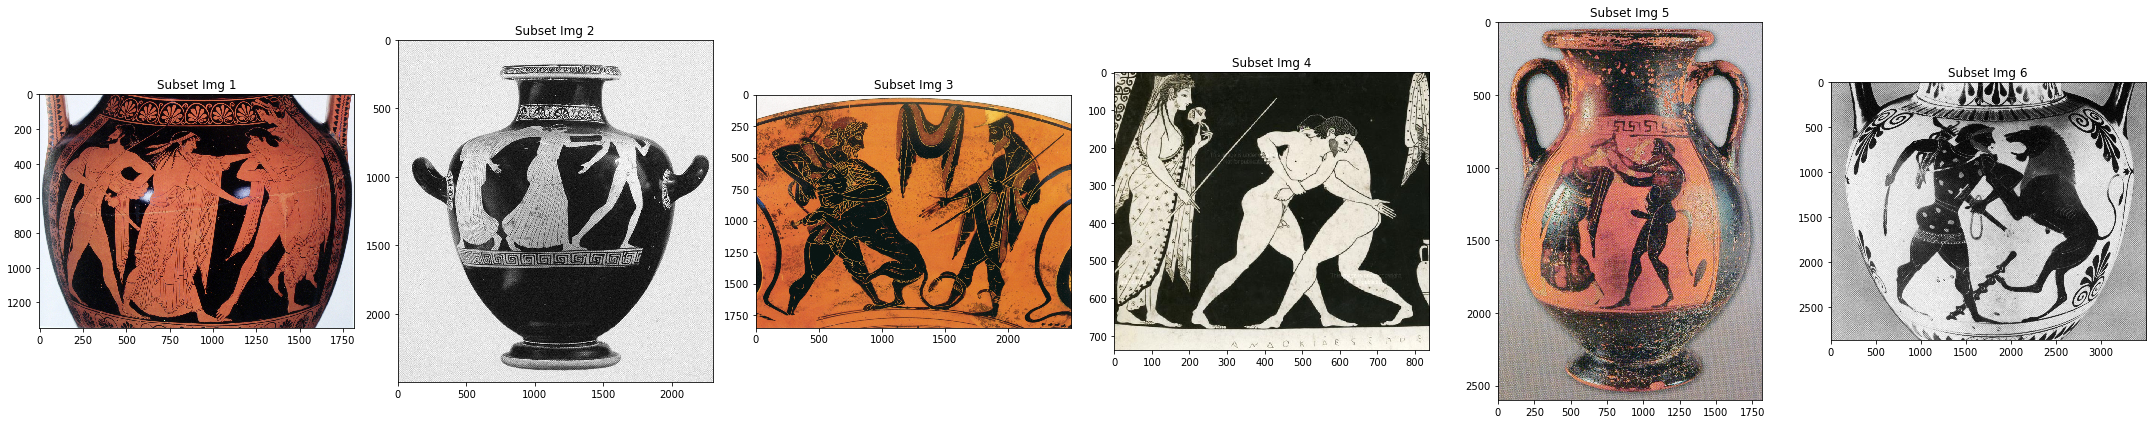

In [6]:
fig, ax = plt.subplots(1,6)
fig.set_size_inches(30,6)
for i in range(6):
    title = f"Subset Img {i+1}"
    visualizations.visualize_image(imgs[i], ax=ax[i], preprocess=True, title=title)
plt.tight_layout()

# 2. Person Detection

In [42]:
IMAGE = 3

In [43]:
# original torchvision implementation
detector_torch = fasterrcnn_resnet50_fpn(pretrained=True)
detector_torch = DataParallel(detector_torch).eval()

In [44]:
# detector with replaced RPN and classification head
# This model has been trained for 25 epochs on MS-COCO to detect persons
detector_tuned = model_setup.setup_detector()
detector_tuned = DataParallel(detector_tuned)
pretrained_path = os.path.join(detector_path, "checkpoint_epoch_25.pth")
checkpoint = torch.load(pretrained_path)
detector_tuned.load_state_dict(checkpoint['model_state_dict'])
detector_tuned = detector_tuned.eval()

In [45]:
# forward pass for predicting bboxes, labels and scores
img = imgs[IMAGE][np.newaxis, :]
outputs_torch = detector_torch(img / 255)
outputs_tuned = detector_tuned(img / 255)

In [48]:
boxes_torch, labels_torch, scores_torch = bbox_lib.bbox_filtering(outputs_torch, filter_=1, thr=0.3)
boxes_tuned, labels_tuned, scores_tuned = bbox_lib.bbox_filtering(outputs_tuned, filter_=1, thr=0.3)

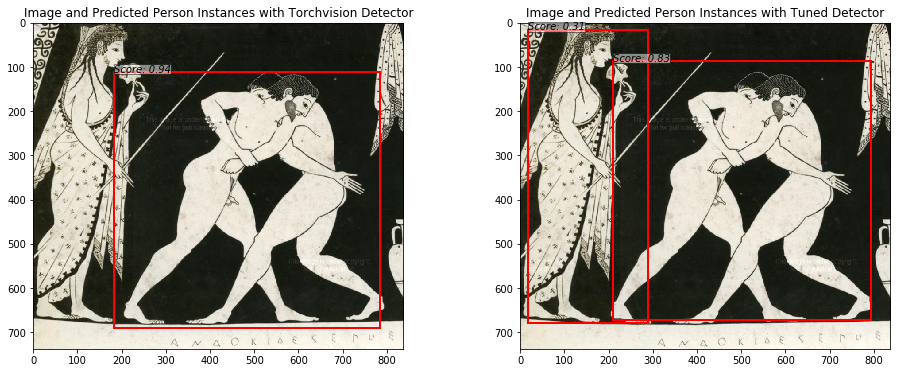

In [49]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(16,6)

title = "Image and Predicted Person Instances with Torchvision Detector"
visualizations.visualize_bbox(img[0,:].cpu().numpy().transpose(1,2,0) / 255, 
                              boxes=boxes_torch[0],  labels=labels_torch[0],
                              scores=scores_torch[0], ax=ax[0], title=title)

title = "Image and Predicted Person Instances with Tuned Detector"
visualizations.visualize_bbox(img[0,:].cpu().numpy().transpose(1,2,0) / 255, 
                              boxes=boxes_tuned[0],  labels=labels_tuned[0],
                              scores=scores_tuned[0], ax=ax[1], title=title)

plt.show()

# 3. Cropping and Scaling

In [50]:
get_detections = TransformDetection(det_width=192, det_height=256)

In [51]:
img_extract = img[0,:].numpy().transpose(1,2,0)
detections, centers, scales = get_detections(img=img_extract, list_coords=boxes_tuned[0])
# detections, centers, scales = get_detections(img=img_extract, list_coords=boxes_torch[0])

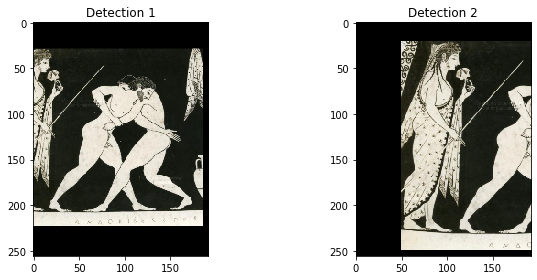

In [52]:
n_dets = detections.shape[0]
fig, ax = plt.subplots(1, n_dets)
if(n_dets == 1):
    ax = [ax]
fig.set_size_inches(5*n_dets, 4)
for i,det in enumerate(detections):
    title = f"Detection {i+1}"
    visualizations.visualize_image(det, ax=ax[i], preprocess=True, title=title)
plt.tight_layout()

# 4. Keypoint Detection

In [53]:
normalize = transforms.Normalize(
                mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
            )
normed_detections = [normalize(torch.Tensor(det/255)).numpy() for det in detections]

In [54]:
# HRNet Model instance
untrained_model = model_setup.load_model(exp_data)
untrained_model = DataParallel(untrained_model)
checkpoint_path = os.path.join(models_path, "checkpoint_epoch_100.pth")
# checkpoint_path = os.path.join(models_path, "checkpoint_epoch_10.pth")
hrnet_model = model_setup.load_checkpoint(checkpoint_path, untrained_model, only_model=True).eval()
# hrnet_model =  model_setup.load_model(exp_data)

In [55]:
# forward pass through HTNer for keypoint detection
keypoint_dets = hrnet_model(torch.Tensor(normed_detections).float())
scaled_dets = F.interpolate(keypoint_dets.clone().detach(), (256, 192),
                            mode="bilinear", align_corners=True)

In [56]:
keypoint_coords, max_vals = pose_parsing.get_max_preds_hrnet(scaled_dets.cpu().detach().numpy())
indep_pose_entries, indep_all_keypoints = pose_parsing.create_pose_entries(keypoint_coords,  max_vals, thr=0.1)

In [57]:
# detecting keypoint detection and pose parsing
keypoints, max_vals, coords = pose_parsing.get_final_preds_hrnet(keypoint_dets.cpu().detach().numpy(), centers, scales)
pose_entries, all_keypoints = pose_parsing.create_pose_entries(keypoints, max_vals, thr=0.1)

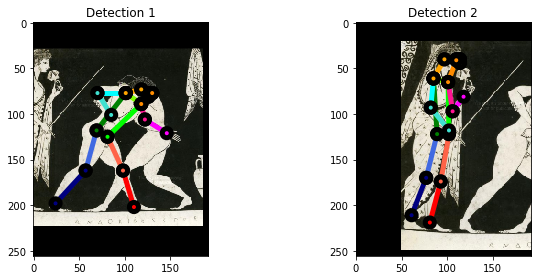

In [58]:
indep_all_keypoints = [indep_all_keypoints[:, 1], indep_all_keypoints[:, 0], indep_all_keypoints[:, 2], indep_all_keypoints[:, 3]]
indep_all_keypoints = np.array(indep_all_keypoints).T

n_dets = detections.shape[0]
fig, ax = plt.subplots(1, n_dets)
if(n_dets == 1):
    ax = [ax]
fig.set_size_inches(5*n_dets, 4)
for i,det in enumerate(detections):
    title = f"Detection {i+1}"
    visualizations.draw_pose(det, [indep_pose_entries[i]], indep_all_keypoints,
                             ax=ax[i], title=title, preprocess=True)
plt.tight_layout()

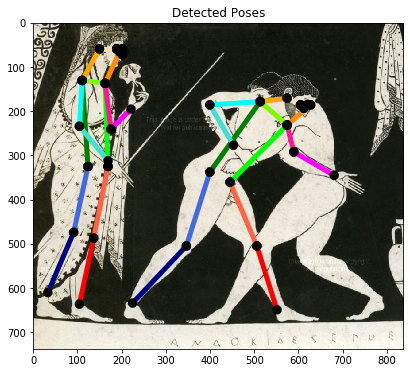

In [59]:
all_keypoints = [all_keypoints[:, 1], all_keypoints[:, 0], all_keypoints[:, 2], all_keypoints[:, 3]]
all_keypoints = np.array(all_keypoints).T

fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,6)

title = f"Detected Poses"
visualizations.draw_pose(img[0,:].cpu().numpy().transpose(1,2,0) / 255,
                         pose_entries, all_keypoints, ax=ax, title=title)

<div class=alert style="background-color:#F5F5F5; border-color:#C8C8C8">
   This notebook was created by <b>Angel Villar-Corrales</b>
</div> 